In [44]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.


import numpy as np
import pandas as pd
import csss as CSSS
import sqlalchemy as sq
import matplotlib.pyplot as plt
import pytz
import datetime as dt
from time import time
import pickle as pk

% matplotlib inline

In [14]:
## Close any open connections. 
import gc
for obj in gc.get_objects():
    if isinstance(obj, sq.engine.base.Engine):
        obj.dispose()
        
## Read key for PecanSt, Stored in text file
with open('keys/pecanstkey.txt','r') as f:
    key = f.read().strip()
    f.close()
    
    
## Create engine
engine = sq.create_engine("postgresql+psycopg2://{}@dataport.pecanstreet.org:5434/postgres".format(key))

## Identify homes with complete data from Pecan Street
Isolate dates in 2015 and 2016

In [15]:
query="""
SELECT dataid, count(*)
FROM university.electricity_egauge_15min
WHERE local_15min
BETWEEN '01-01-2015' AND '01-01-2017'
GROUP BY dataid
"""
datacounts = pd.read_sql_query(query,engine)
c = np.max(datacounts['count'])

In [38]:
print(c)
datacounts.head()

70169


,dataid,count
0,3368,70169
1,4874,70169
2,6800,8744
3,9585,2376
4,3401,64217


In [36]:
query = "SELECT dataid, city from university.metadata"
metadata = pd.read_sql_query(query, engine)
metadata = metadata.merge(datacounts)
duse = metadata[(metadata['count'] >= c ) & (metadata['city'] == 'Austin')]['dataid'].values

In [37]:
duse

array([1790, 3577, 2575, 5785,  114,  370,  545,  585,  661,  744, 1192,
       1463, 1642, 1800, 2018, 2129, 2233, 2337, 2814, 2818, 2859, 2945,
       3009, 3039, 3456, 3482, 3918, 3967, 4031, 4767, 4998, 5275, 5403,
       5545, 5972, 6423, 6990, 7024, 7504, 7536, 7940, 8084, 8236, 8317,
       8767, 8829, 9134, 9160, 9729,  624, 1953, 2199, 2365, 2378, 2787,
       4298, 5026, 5035, 7390, 7788, 7951, 8142, 2094, 8626, 6643,  890,
       7429, 5892, 4357,  171, 5439, 4154, 2829, 9654, 5874,   93,  484,
        871, 3831, 5949, 6139, 6730, 7361, 7769, 7989, 9019, 9609, 9915,
       9922, 9932, 9934, 9935, 9938, 9942, 2755, 3367, 1403,  187,  252,
       1103, 1169, 1283, 1415, 1697, 1792, 2925, 2965, 2980, 2986, 3134,
       3538, 3935, 4297, 4373, 5129, 5738, 5796, 5921, 6578, 7560, 7627,
       7739, 7800, 7850, 7900, 8156, 8386, 9052, 9971, 9982, 6498, 1632,
       3392, 8059,   77, 2072, 3849, 4352, 4514, 8086, 8419, 9248, 4874,
       5677,  946, 7641, 4641, 8292, 9875, 6121, 49

## Daylight Savings Time
It appears that pecan street consistently drops one hour each year when daylight savings time ends. At the onset of DST, the local time skips from 1:45 to 3:00 as it should. At the conclusion of DST, there are no additional 2am readings. Possibly this is an artifact of only the 15-minute data. 

In [41]:
## Get data from all homes with complete data (about 200)
ti = time()
query="""SELECT dataid, local_15min, use, gen, air1, air2, air3, airwindowunit1, furnace1, furnace2 
FROM university.electricity_egauge_15min
WHERE local_15min
BETWEEN '01-01-2015' AND '01-01-2016' AND electricity_egauge_15min.dataid in (""" + \
','.join([str(d) for d in duse]) + \
""");"""

the_frame = pd.read_sql_query(query,engine)
#the_frame.sort_values('local_15min')
the_frame.tail()
tf = time()
deltat = (tf - ti) / 60.
print('Query took {:.2f} minutes'.format(deltat))

Query took 58.55 minutes


In [45]:
## Localize the time and add a date column. 
the_frame["time"] = the_frame.set_index("local_15min").index.tz_localize(pytz.timezone('America/Chicago'), ambiguous = True)
the_frame["date"] = [ dt.datetime(d.year,d.month,d.day,0,0,0,0) for d in the_frame['time'] ]


In [76]:
loaddata.sort_index()

local_15min       use       gen  \
dataid time                                                                
26     2015-01-01 00:00:00-06:00 2015-01-01 00:00:00  1.909200  0.002067   
       2015-01-01 00:15:00-06:00 2015-01-01 00:15:00  2.061667  0.002333   
       2015-01-01 00:30:00-06:00 2015-01-01 00:30:00  2.177800  0.004667   
       2015-01-01 00:45:00-06:00 2015-01-01 00:45:00  2.047000  0.008600   
       2015-01-01 01:00:00-06:00 2015-01-01 01:00:00  1.185467  0.001867   
       2015-01-01 01:15:00-06:00 2015-01-01 01:15:00  2.105733  0.010267   
       2015-01-01 01:30:00-06:00 2015-01-01 01:30:00  1.724400  0.007067   
       2015-01-01 01:45:00-06:00 2015-01-01 01:45:00  1.046467  0.001133   
       2015-01-01 02:00:00-06:00 2015-01-01 02:00:00  1.060333  0.001600   
       2015-01-01 02:15:00-06:00 2015-01-01 02:15:00  0.726067 -0.001333   
       2015-01-01 02:30:00-06:00 2015-01-01 02:30:00  0.543467 -0.001200   
       2015-01-01 02:45:00-06:00 2015-01-01 02:45:00  0.738267  0.000800   
       2015-01-01 03:00:00-06:00 2015-01-01 03:00:00  0.472000 -0.001000   
       2015-01-01 03:15:00-06:00 2015-01-01 03:15:00  0.447133 -0.001000   
       2015-01-01 03:30:00-06:00 2015-01-01 03:30:00  0.445067 -0.001000   
       2015-01-01 03:45:00-06:00 2015-01-01 03:45:00  0.471400 -0.000933   
       2015-01-01 04:00:00-06:00 2015-01-01 04:00:00  0.487133 -0.001000   
       2015-01-01 04:15:00-06:00 2015-01-01 04:15:00  0.334467 -0.002000   
       2015-01-01 04:30:00-06:00 2015-01-01 04:30:00  0.345333 -0.001933   
       2015-01-01 04:45:00-06:00 2015-01-01 04:45:00  0.451400 -0.001133   
       2015-01-01 05:00:00-06:00 2015-01-01 05:00:00  0.426333 -0.001000   
       2015-01-01 05:15:00-06:00 2015-01-01 05:15:00  0.347400 -0.001867   
       2015-01-01 05:30:00-06:00 2015-01-01 05:30:00  0.335533 -0.002000   
       2015-01-01 05:45:00-06:00 2015-01-01 05:45:00  0.396800 -0.002333   
       2015-01-01 06:00:00-06:00 2015-01-01 06:00:00  0.542000 -0.002000   
       2015-01-01 06:15:00-06:00 2015-01-01 06:15:00  0.987133  0.001800   
       2015-01-01 06:30:00-06:00 2015-01-01 06:30:00  0.903333  0.001000   
       2015-01-01 06:45:00-06:00 2015-01-01 06:45:00  0.898933  0.001000   
       2015-01-01 07:00:00-06:00 2015-01-01 07:00:00  0.928333  0.001267   
       2015-01-01 07:15:00-06:00 2015-01-01 07:15:00  1.004600  0.002000   
...                                              ...       ...       ...   
9982   2015-12-31 16:45:00-06:00 2015-12-31 16:45:00  0.531467  0.051933   
       2015-12-31 17:00:00-06:00 2015-12-31 17:00:00  0.527600  0.004933   
       2015-12-31 17:15:00-06:00 2015-12-31 17:15:00  0.718067 -0.014400   
       2015-12-31 17:30:00-06:00 2015-12-31 17:30:00  0.972600 -0.018800   
       2015-12-31 17:45:00-06:00 2015-12-31 17:45:00  1.101333 -0.009933   
       2015-12-31 18:00:00-06:00 2015-12-31 18:00:00  1.096133 -0.005000   
       2015-12-31 18:15:00-06:00 2015-12-31 18:15:00  1.116267 -0.005000   
       2015-12-31 18:30:00-06:00 2015-12-31 18:30:00  0.611000 -0.005000   
       2015-12-31 18:45:00-06:00 2015-12-31 18:45:00  0.769600 -0.005000   
       2015-12-31 19:00:00-06:00 2015-12-31 19:00:00  0.556867 -0.005000   
       2015-12-31 19:15:00-06:00 2015-12-31 19:15:00  0.474200 -0.005000   
       2015-12-31 19:30:00-06:00 2015-12-31 19:30:00  0.450933 -0.005000   
       2015-12-31 19:45:00-06:00 2015-12-31 19:45:00  0.454800 -0.005000   
       2015-12-31 20:00:00-06:00 2015-12-31 20:00:00  0.562200 -0.005000   
       2015-12-31 20:15:00-06:00 2015-12-31 20:15:00  0.512800 -0.005000   
       2015-12-31 20:30:00-06:00 2015-12-31 20:30:00  0.486533 -0.005000   
       2015-12-31 20:45:00-06:00 2015-12-31 20:45:00  0.408467 -0.005000   
       2015-12-31 21:00:00-06:00 2015-12-31 21:00:00  0.510667 -0.005000   
       2015-12-31 21:15:00-06:00 2015-12-31 21:15:00  0.692000 -0.005000   
       2015-12-31 21:30:00-06:00 2015-12-31 21:30:00  0.549867 -0.005000   
       2015-1

In [80]:
loaddata = the_frame.set_index(['time'])

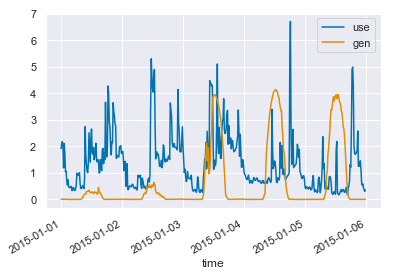

In [59]:
loaddata[loaddata['dataid'] == 26].loc['2015-01-01':'2015-01-05'].plot(y=['use', 'gen'])

In [48]:
## Make a heating and cooling column
loaddata['cooling'] = np.sum(loaddata[['air1','air2','air3','airwindowunit1']], axis = 1)
loaddata['heating'] = np.sum(loaddata[['furnace1','furnace2']], axis = 1)

In [51]:
loadgroup = loaddata[['dataid','use','gen','heating','cooling']].groupby("dataid")
loaddata_counts = loadgroup.count()
loaddata_means  = loadgroup.mean()
loaddata_counts.columns = ['count_' + d for d in loaddata_counts.columns]
loaddata_means.columns  = ['mean_' + d for d in loaddata_means.columns]
load_summary = pd.concat([loaddata_counts,loaddata_means], axis = 1)
# drop dataids that are missing some usage data
load_summary = load_summary.loc[load_summary['count_use'] == np.max(load_summary['count_use']),:]

In [52]:
load_summary

,count_use,count_gen,count_heating,count_cooling,mean_use,mean_gen,mean_heating,mean_cooling
dataid,,,,,,,,
26,35037,35037,35037,35037,1.431471,0.833433,0.109708,0.422090
77,35037,35037,35037,35037,1.628691,0.473140,0.143113,0.684299
93,35037,35037,35037,35037,1.115358,0.795688,0.147360,0.446676
101,35037,0,35037,35037,0.696564,NaN,0.052105,0.246328
114,35037,35037,35037,35037,1.270681,0.525776,0.162593,0.349069
171,35037,35037,35037,35037,0.859805,0.809995,0.000000,0.000000
252,35037,35037,35037,35037,2.455430,0.737062,0.000000,0.000000
434,35037,0,35037,35037,1.745331,NaN,0.148005,0.792689
484,35037,0,35037,35037,1.234700,NaN,0.023084,0.305298


In [60]:
print('There are %d homes with complete data' % load_summary.shape[0])
print('%d homes solar' % np.sum(load_summary['count_gen']>0))
print('%d homes cooling' % np.sum(load_summary['count_cooling']>0))
print('%d homes heating' % np.sum(load_summary['count_heating']>0))

There are 183 homes with complete data
114 homes solar
183 homes cooling
183 homes heating


### Select 4 homes without solar

In [65]:
np.sort(np.random.choice(load_summary.index[load_summary['count_gen']==0] , 4, replace=False))

array([4998, 5949, 7641, 8292])

### Select 6 homes with solar

In [66]:
np.sort(np.random.choice(load_summary.index[load_summary['count_gen']==0] , 6, replace=False))

array([5809, 6460, 8282, 9484, 9912, 9938])

In [43]:
loaddata = the_frame
loaddata["time"] = loaddata.set_index("local_15min").index.tz_localize(pytz.timezone('America/Chicago'), ambiguous = True)
loaddata["date"] = [ dt.datetime(d.year,d.month,d.day,0,0,0,0) for d in loaddata['time'] ]

## Dump as a pickle file. 
import pickle as pk
pk.dump( loaddata, open( "data/demand.pkl", "wb" ) )

## Weather Data
Weather data are from three locations: Austin, Boulder and San Diego.  There is no way to tell which home is in each location.  I will label and keep all of them.

In [44]:
locs =pd.read_sql_query("""SELECT distinct(latitude,longitude), latitude FROM university.weather LIMIT 10;""",engine)
locs['Location'] = ['Austin','San Diego','Boulder']
locs

,row,latitude,Location
0,"(30.292432,-97.699662)",30.292432,Austin
1,"(32.778033,-117.151885)",32.778033,San Diego
2,"(40.027278,-105.256111)",40.027278,Boulder


In [45]:
weather = pd.read_sql_query("""
SELECT * FROM university.weather  
WHERE localhour
BETWEEN '01-01-2015' AND '01-01-2016'
;
""", engine)

In [46]:
weather = weather.merge(locs[['latitude','Location']])
weather.head()

,localhour,latitude,longitude,tz_offset,summary,ozone,ozone_error,temperature,temperature_error,dew_point,...,wind_speed,wind_speed_error,cloud_cover,cloud_cover_error,wind_bearing,precip_intensity,precip_intensity_error,precip_probability,precip_type,Location
0,2015-08-23 13:00:00-05:00,40.027278,-105.256111,-6,Clear,287.11,None,67.27,None,41.72,...,2.15,None,0.13,None,66,0.0,None,0.0,None,Boulder
1,2015-09-06 03:00:00-05:00,40.027278,-105.256111,-6,Clear,276.72,None,65.97,None,43.65,...,2.05,None,0.07,None,269,0.0,None,0.0,None,Boulder
2,2015-09-25 22:00:00-05:00,40.027278,-105.256111,-6,Clear,263.95,None,63.46,None,41.04,...,0.89,None,0.00,None,160,0.0,None,0.0,None,Boulder
3,2015-09-25 23:00:00-05:00,40.027278,-105.256111,-6,Clear,262.46,None,61.34,None,41.05,...,0.68,None,0.00,None,220,0.0,None,0.0,None,Boulder
4,2015-09-26 10:00:00-05:00,40.027278,-105.256111,-6,Clear,248.03,None,60.14,None,39.87,...,0.32,None,0.00,None,43,0.0,None,0.0,None,Boulder


In [47]:
pk.dump( weather, open( "data/weather.pkl", "wb" ) )